In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

rng  = np.random.default_rng(1234)

In [2]:

def u(t):
    return 1
    return np.sin(0.1*t)+1

delta = 0.5
x0 = 20.
c = 5.

def temperature_mass_system(t,x):
    # delta, x0, c = args
    return -delta*(x-x0) + c*u(t)
    

In [23]:
t = np.arange(0,50.1,0.1)
sol = solve_ivp(
    temperature_mass_system,
    t_span=[t[0],t[-1]],
    t_eval=t,
    y0=[15.],
    method='LSODA'
)

In [24]:
t_true = sol.t
u_true = np.array([u(ti) for ti in t_true])
x_true = sol.y[0]
xdot_true = temperature_mass_system(t_true, x_true)

In [25]:
var = 0.1
t_train = t_true[::10]
u_train = np.array([u(ti) for ti in t_train])
x_train = x_true[::10] + var*rng.normal(0,1,x_true[::10].shape)

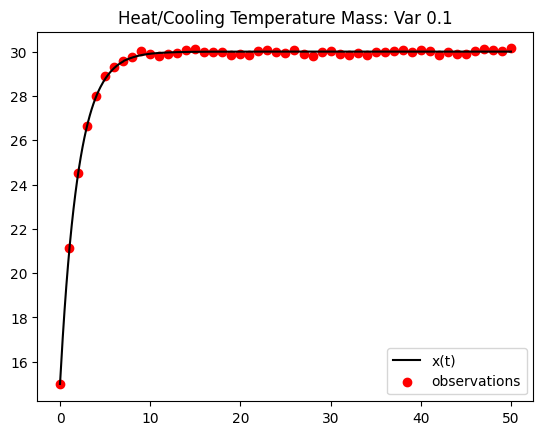

In [26]:
plt.plot(sol.t,sol.y[0], label='x(t)',c='black')
plt.scatter(t_train, x_train, label='observations',c='red')
plt.title(f"Heat/Cooling Temperature Mass: Var {var}")
plt.legend()
plt.show()


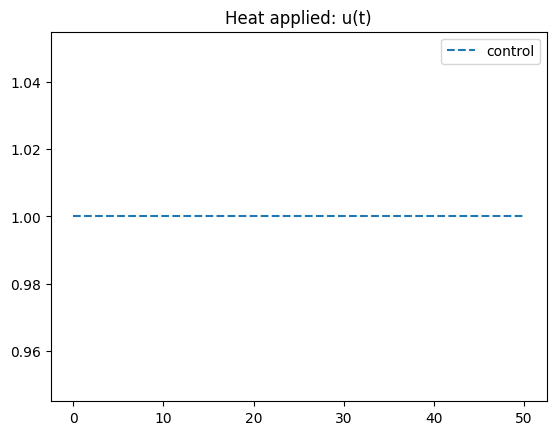

In [27]:
plt.plot(t,[u(ti) for ti in t], linestyle='--',label='control')
plt.title("Heat applied: u(t)")
plt.legend()
plt.show()

# Kernel Method

In [28]:
# just try out of the box opt first
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.gaussian_process.kernels import RationalQuadratic, DotProduct
from scipy.signal import savgol_filter
from scipy.optimize import minimize
from kernels import affine_kernel

In [29]:
x_u_train = np.vstack([x_train,u_train]).T
# K_g = rbf_kernel(x_u_train,x_u_train,gamma=0.1)

In [30]:
# rq_kernel = RationalQuadratic(length_scale=1.0,alpha=1) + DotProduct()
# rq_kernel = DotProduct()
# Kf = rq_kernel(x_train.reshape(-1,1))
# Kf = rbf_kernel(x_train.reshape(-1,1),x_train.reshape(-1,1),gamma=0.01)
# x_u_train = np.vstack([x_train,u_train]).T
# Kg = rbf_kernel(x_u_train,x_u_train,gamma=1)

Kf = affine_kernel(x_train.reshape(-1,1),gamma1=1,gamma2=2)
Kg = affine_kernel(x_u_train,gamma1=1)




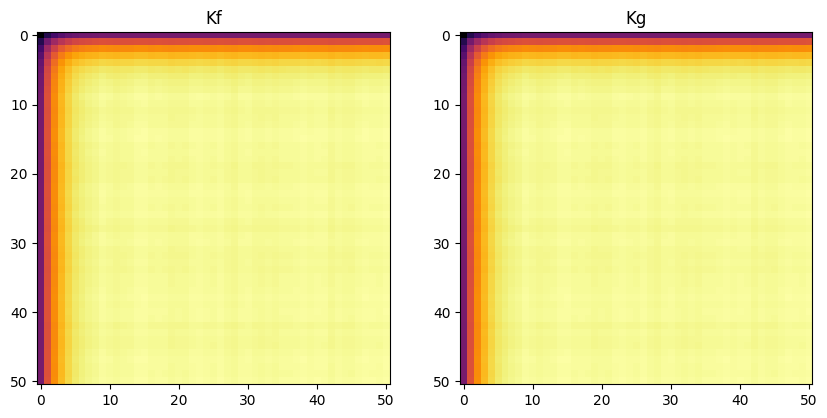

In [31]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].imshow(Kf,cmap='inferno')
axs[0].set_title("Kf")

axs[1].imshow(Kg, cmap='inferno')
axs[1].set_title("Kg")
plt.show()

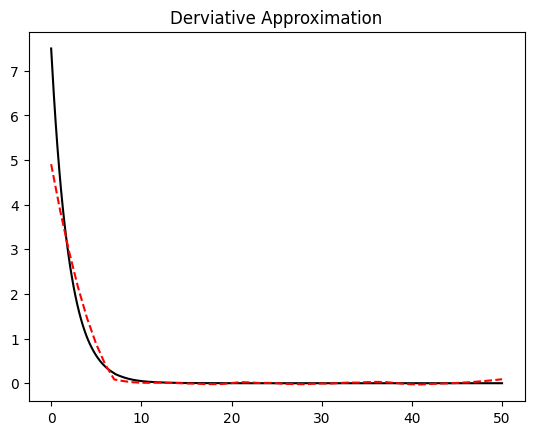

In [32]:
xdot_approx = savgol_filter(x_train, window_length=15,polyorder=3,deriv=1,delta=t_train[1]-t_train[0])

plt.plot(t_true,xdot_true, label="True derviative",c='black')
plt.plot(t_train,xdot_approx,linestyle='--',label='approx',c='red')
plt.title("Derviative Approximation")
plt.show()

In [33]:
N = len(x_train)
a=-1
b=1

eps = 1e-3

def sigmoid(z):
    return 1 / (1+np.exp(-z))

lam_f = 0.01
lam_g = 1.
def loss_k(params):
    alpha = params[:N]
    beta = params[N:]

    fk = Kf@alpha
    gk = Kg@beta

    # fk = -(fk)**2
    # gk = a + (b-a)*sigmoid(gk)

    resid = xdot_approx - fk*(x_train.flatten() - gk)
    reg = lam_f/2*alpha.T@Kf@alpha + lam_g/2*beta.T@Kg@beta -eps*np.mean((Kf@alpha)**2)
    loss = np.mean(resid**2) + reg
    return loss


In [34]:
x0_opt = np.zeros(2*N)
sol_opt = minimize(loss_k,x0_opt,method='L-BFGS-B')

In [35]:
alpha_star = sol_opt.x[:N]
beta_star = sol_opt.x[N:]
alpha_star, beta_star

(array([ 0.45840745,  0.30241819,  0.19269678,  0.11453059,  0.06242533,
         0.02677908,  0.01016269, -0.00194935, -0.00957151, -0.02121804,
        -0.01615771, -0.01162517, -0.01503936, -0.01683328, -0.02392386,
        -0.02456744, -0.01825783, -0.01977658, -0.0185699 , -0.01374883,
        -0.01519345, -0.01432739, -0.02110282, -0.02336765, -0.01933319,
        -0.01788556, -0.02288973, -0.0159732 , -0.01147796, -0.01963456,
        -0.02132942, -0.0153198 , -0.01382869, -0.01694045, -0.01395811,
        -0.01861057, -0.01870759, -0.0205227 , -0.02374151, -0.01979524,
        -0.02229845, -0.02178854, -0.01301306, -0.01887439, -0.01526537,
        -0.01488267, -0.02016251, -0.02439737, -0.02257174, -0.02175281,
        -0.02596974]),
 array([-0.00021008, -0.00023979, -0.00025624, -0.00026667, -0.00027318,
        -0.00027745, -0.00027939, -0.00028079, -0.00028167, -0.000283  ,
        -0.00028242, -0.0002819 , -0.00028229, -0.0002825 , -0.0002833 ,
        -0.00028338, -0.0002

In [36]:
alpha_star.shape, beta_star.shape

((51,), (51,))

In [37]:
def f_star(x):
    Kf = rbf_kernel(x,x_train.reshape(-1,1),gamma=1)
    # return -(Kf@alpha_star)**2  
    return -np.exp(Kf@alpha_star)

def g_star(x,u):
    input = np.vstack([x,u]).T
    Kg = rbf_kernel(input, x_u_train)
    return a + (b-a)*sigmoid(Kg@beta_star)

In [38]:
f_out = f_star(x_train.reshape(-1,1))
g_out = g_star(x_train,u_train)

# xdot_k_approx = f_out*(x_train - g_out)

In [39]:
f_true = np.array([-delta]*len(x_true))
g_true = -delta*(x_true - x0) + c*np.array([u(ti) for ti in t])

In [40]:
f_true.shape

(501,)

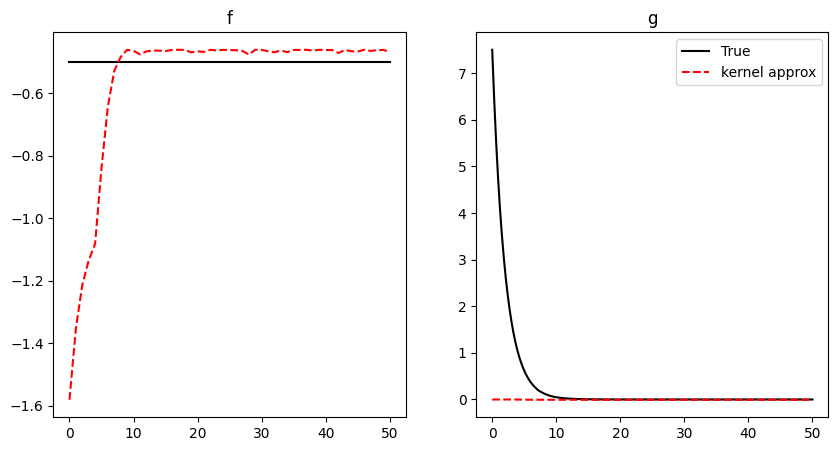

In [41]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(t,f_true,c='black')
axs[0].plot(t_train, f_out,linestyle='--',c='red')
axs[0].set_title("f")


axs[1].plot(t,g_true,c='black', label='True')
axs[1].plot(t_train, g_out,linestyle='--',c='red', label='kernel approx')
axs[1].set_title("g")

plt.legend()
plt.show()